### This notebook provides the Temporal Kolmogorov-Arnold Network sources code for our work titled "Localized Weather Prediction using Kolmogorov-Arnold Networks and Deep RNNs". 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
# from spline import  BSplineActivation, FixedSplineActivation
# from  Kan_Layer import *
import time
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torchmetrics.regression import MeanAbsolutePercentageError, R2Score,MeanSquaredError,MeanAbsoluteError
from utils import EarlyStopping,KAN,KANLinear,kan_prediction_plots,TKANCell,TKAN,create_data_loaders,TimeSeriesDataset
np.random.seed(142)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import time

/Users/ange-clementakazan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# data for Abidjan
parent_dir="/Users/ange-clementakazan/Documents/Weather_Prediction_project/Deep-Learning-for-Weather-Prediction/data"
Abj_dt = pd.read_csv(parent_dir+'/Abidjan_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})
# data for Kigali
Kgl_dt = pd.read_csv(parent_dir+'/Kigali_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})

# print(df.info())
# df.describe(),data_.describe()
# df.head(4) 
# Abj_dt 
#Rename Columns
col_name_map = {
    "ALLSKY_SFC_SW_DWN": "ASWD",
    "CLRSKY_SFC_SW_DWN":"CSWD","ALLSKY_SFC_LW_DWN":"ALWD","PRECTOTCORR":"PREC"
}
# new_colnames=['datetime', 'ASWD', 'CSWD',
#        'ALWD', 'T2M', 'T2MDEW', 'T2MWET', 'QV2M', 'RH2M',
#        'PREC', 'PS']
# Rename the columns for both datasets
Abj_dt=Abj_dt.set_index("datetime")
Kgl_dt=Kgl_dt.set_index("datetime")
Abj_dt=Abj_dt.rename(columns=col_name_map)
Kgl_dt =Kgl_dt.rename(columns=col_name_map)
# Xy_train
# target_col = Abj_dt.pop("T2M")
# Abj_dt.insert(len(Abj_dt.columns),"T2M", target_col)
# Abj_dt
# target_col = Abj_dt.pop("PREC")
# Abj_dt.insert(len(Abj_dt.columns),"PREC", target_col)
# Abj_dt

/var/folders/nv/ct8x_h9j78xbj8gnyb35c3_w0000gn/T/ipykernel_26024/288030412.py:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  Abj_dt = pd.read_csv(parent_dir+'/Abidjan_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})
/var/folders/nv/ct8x_h9j78xbj8gnyb35c3_w0000gn/T/ipykernel_26024/288030412.py:5: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  Kgl_dt = pd.read_csv(parent_dir+'/Kigali_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})


In [3]:
dates=Abj_dt.index.astype(str).tolist()
dates=Kgl_dt.index.astype(str).tolist()
# # Abj_dt
len(dates)

5114

In [212]:
#################### Datapreprocessing For Temperature   #####################
import copy
# Sorting the dates
def Make_tidydata(data,scaler,var_name):
    # dt=copy.ddata
    # print((data.columns))
    target_col=data.pop(var_name)
    data.insert(len(data.columns), var_name, target_col)
    data= data.sort_index()
    data[data.columns] = scaler.fit_transform(data[data.columns])
    # Splitting the dataset into training, validation, and test sets
    train_size = int(len(data)*0.8)
    val_size =int(train_size*0.10)
    #Train_val_test sets
    Xy_train = data[:train_size-val_size]
    Xy_val= data[train_size-val_size:train_size]
    Xy_test=data[train_size:]
    return Xy_train,Xy_val,Xy_test

# Create DataLoaders for Abidjan and Kigali
batch_size = 64
window_length = 1
obs_length=14
scaler=[MinMaxScaler(feature_range=(0,1)),MinMaxScaler(feature_range=(0,1))]
target_names='PREC' #, Choose between 'PREC', 'T2M', and 'PS'
Abj_train_loader,Abj_val_loader,Abj_test_loader=create_data_loaders(TimeSeriesDataset,Make_tidydata,Abj_dt,target_names,scaler[0],window_length,obs_length,batch_size)
Kgl_train_loader,Kgl_val_loader,Kgl_test_loader=create_data_loaders(TimeSeriesDataset,Make_tidydata,Kgl_dt,target_names,scaler[1],window_length,obs_length,batch_size)

In [224]:
def dates_splitting(date):
    # Splitting the dataset into training, validation, and test sets
    train_size = int(len(date)*0.8)
    val_size =int(train_size*0.10)
    #Train_val_test sets
    date_train = date[:train_size-val_size]
    date_val= date[train_size-val_size:train_size]
    date_test=date[train_size:]
    return date_train,date_val,date_test

date_train,date_val,date_test=dates_splitting(dates)

In [225]:
len(date_test)
# date_test

1023

# Kigali Training

In [194]:
# inputs = torch.rand((32, 10, 8))  # batch_size=32, sequence_length=10, input_size=8
#targets = torch.randint(0, 2, (32, 4)).float()  # Пример целей для обучения
input_shape=Kgl_dt.shape
sub_kan_input_dim=input_shape[-1]
sub_kan_output_dim=2*sub_kan_input_dim+1
units=1
layers_hidden=[sub_kan_input_dim,sub_kan_output_dim]
# print(layers_hidden)
print("target_names:",target_names)
max_order=2
# sub_kan_input_dim
# tkan_layer 
model= TKAN(units, layers_hidden,max_order,tkan_activations=KAN) 

# Setting up the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
#criterion = nn.BCELoss()
criterion = nn.MSELoss()
# # Training loop
epochs = 100
for epoch in range(epochs): 
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in Kgl_train_loader:
        X_batch, y_batch=X_batch.to(device), y_batch.to(device).reshape(-1,1)
        optimizer.zero_grad()   # Reset gradients
        # with torch.autograd.detect_anomaly(check_nan=True):
        outputs, _  = model(X_batch)
        outputs = outputs[:, -1]
        
        
        loss = criterion(outputs, y_batch)
        # with torch.autograd.set_detect_anomaly(True):
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
   
    # print(outputs[:4], y_batch[:4])
    if epoch % 10 == 0:  # Print loss every 10 epochs
        # print("ybatch:",y_batch.shape, "output:",outputs.shape)
        # with torch.no_grad():
        #     grad = torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None])
        print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss / len(Kgl_train_loader)} ") #:.4f print("ybatch:",y_batch.shape, "output:",outputs.shape)
        
print("Training complete! 🚀")



target_names: PREC
Epoch [0/100], Loss: 0.004762646601663838 
Epoch [10/100], Loss: 0.0035630430447154454 
Epoch [20/100], Loss: 0.003440405291320499 
Epoch [30/100], Loss: 0.0033508808201390666 
Epoch [40/100], Loss: 0.0032763626949072833 
Epoch [50/100], Loss: 0.0032213845245458853 
Epoch [60/100], Loss: 0.0031784941285626827 
Epoch [70/100], Loss: 0.0031540578924062266 
Epoch [80/100], Loss: 0.0031417787525650307 
Epoch [90/100], Loss: 0.003134230093313943 
Training complete! 🚀


# Abidjan Training

In [174]:
# inputs = torch.rand((32, 10, 8))  # batch_size=32, sequence_length=10, input_size=8
#targets = torch.randint(0, 2, (32, 4)).float()  # Пример целей для обучения
input_shape=Abj_dt.shape
sub_kan_input_dim=input_shape[-1]
sub_kan_output_dim=2*sub_kan_input_dim+1
units=1
layers_hidden=[sub_kan_input_dim,sub_kan_output_dim]
print("target_names:",target_names)
max_order=2
# sub_kan_input_dim
# tkan_layer 
model_= TKAN(units, layers_hidden,max_order,tkan_activations=KAN) 

# Setting up the optimizer and loss function
optimizer_ = optim.Adam(model_.parameters(), lr=0.001)
#criterion = nn.BCELoss()
criterion = nn.MSELoss()
# # Training loop
epochs = 100
for epoch in range(epochs): 
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in Abj_train_loader:
        X_batch, y_batch=X_batch.to(device), y_batch.to(device).reshape(-1,1)
        optimizer_.zero_grad()   # Reset gradients
        # with torch.autograd.detect_anomaly(check_nan=True):
        outputs, _  = model_(X_batch)
        outputs = outputs[:, -1]
        
        
        loss = criterion(outputs, y_batch)
        # with torch.autograd.set_detect_anomaly(True):
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer_.step()
        epoch_loss += loss.item()
   
    # print(outputs[:4], y_batch[:4])
    if epoch % 10 == 0:  # Print loss every 10 epochs
        # print("ybatch:",y_batch.shape, "output:",outputs.shape)
        # with torch.no_grad():
        #     grad = torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None])
        print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss / len(Abj_train_loader)} ") #:.4f print("ybatch:",y_batch.shape, "output:",outputs.shape)
        
print("Training complete! 🚀")



target_names: PREC
Epoch [0/100], Loss: 0.01992398378407133 
Epoch [10/100], Loss: 0.005297084037888923 
Epoch [20/100], Loss: 0.0036104771392399863 
Epoch [30/100], Loss: 0.0034477944530502506 
Epoch [40/100], Loss: 0.0033823199603297137 
Epoch [50/100], Loss: 0.003335913936537289 
Epoch [60/100], Loss: 0.0032977468250339433 
Epoch [70/100], Loss: 0.0032643654957265145 
Epoch [80/100], Loss: 0.0032336264560179754 
Epoch [90/100], Loss: 0.0032043501419609347 
Training complete! 🚀


## Abidjan

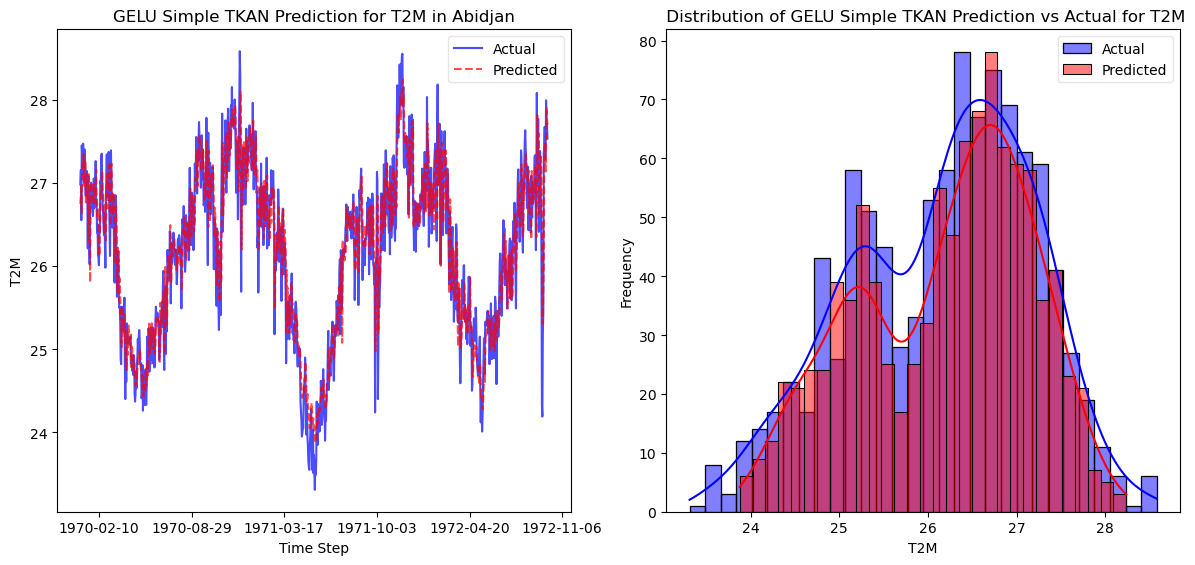

In [166]:
import matplotlib.dates as mdates
y_true_list=[]
y_pred_list=[]
model_name="GELU Simple TKAN"
col=0
metrics_list=[]

var_name,city="T2M","Abidjan"
fig, axes = plt.subplots( 1,2, figsize=(12, 6))
dates=date_test[14:]
with torch.no_grad():
    for X_batch, y_batch in Abj_test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).squeeze()
        outputs,_ = model_(X_batch)
        outputs=outputs[:, -1,:].reshape(-1, 1)
        y_true_list.append(y_batch.cpu().numpy())
        y_pred_list.append(outputs.cpu().numpy())

    # Convert lists to NumPy arrays
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    # print(y_true .shape, y_pred.shape)
    # Inverse transform
    dummy_features = np.zeros((y_true.shape[0], X_batch.shape[2]-1 ))
    actuals_padded = np.hstack([dummy_features, y_true.reshape(-1, 1)])
    predictions_padded = np.hstack([dummy_features, y_pred.reshape(-1, 1)])
    # print("actuals_padded shape:",actuals_padded.shape, "Xbatch shape:", X_batch.shape,"predictions_padded shape:",predictions_padded.shape)
    actuals_ = scaler[col].inverse_transform(actuals_padded)[:, -1] # unscaled output result 
    predictions_ = scaler[col].inverse_transform(predictions_padded)[:, -1] # unscaled prediction result 
    # print( predictions_ [:10],actuals_ [:10]) 
    # Compute metrics
    mse_ = np.mean((actuals_ - predictions_) ** 2)
    rmse_ = np.sqrt(mse_)
    mae_ = np.mean(np.abs(actuals_ - predictions_))
    r2_ = 1 - (np.sum((actuals_ - predictions_) ** 2) / np.sum((actuals_ - np.mean(actuals_)) ** 2))

    mask = actuals_ != 0
    mape_ = np.mean(np.abs((actuals_[mask] - predictions_[mask]) / actuals_[mask])* 100) if mask.any() else np.nan

    # Store metrics
    metrics_list.append({
        "City": city,
        "Model":model_name,
        "Variable": var_name,
        "MSE": round(mse_,4),
        "RMSE": round(rmse_,4),
        "MAE": round(mae_,4),
        "R²": round(r2_,4),
        "MAPE": round(mape_,4)
    })
    # --- Subplot 1: Line Plot ---
    # dates=
    axes[0].plot(dates, actuals_, label="Actual", color="blue", alpha=0.7)
    axes[0].plot(dates, predictions_, label="Predicted", color="red", linestyle="dashed", alpha=0.7)
    axes[0].set_title(f"{model_name} Prediction for {var_name} in {city}")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel(var_name)
    axes[0].legend(framealpha=0.5)
    axes[0].xaxis.set_major_locator(mdates.DayLocator(interval=200))  # Show every 7th day
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format: YYYY-MM-DD
    # plt.yscale('log')
    # axes[ 0].tick_params(axis="x", rotation=45)  # ✅ Correct


    # --- Subplot 2: Histogram ---
    sns.histplot(actuals_, label="Actual", color="blue", kde=True, bins=30, alpha=0.5, ax=axes[1])
    sns.histplot(predictions_, label="Predicted", color="red", kde=True, bins=30, alpha=0.5, ax=axes[1])
    axes[1].set_title(f" Distribution of {model_name} Prediction vs Actual for {var_name}")
    axes[1].set_xlabel(var_name)
    axes[1].set_ylabel("Frequency")
    axes[1].legend(framealpha=0.5)
    
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle

plt.savefig(f"{city}_{var_name}_{model_name}.png")
plt.show()
    # print(idx_d)
# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)

In [167]:
metrics_df

,City,Model,Variable,MSE,RMSE,MAE,R²,MAPE
0,Abidjan,GELU Simple TKAN,T2M,0.1509,0.3885,0.2947,0.8574,1.1284


In [168]:
metrics_df.to_latex()

'\\begin{tabular}{llllrrrrr}\n\\toprule\n & City & Model & Variable & MSE & RMSE & MAE & R² & MAPE \\\\\n\\midrule\n0 & Abidjan & GELU Simple TKAN & T2M & 0.150900 & 0.388500 & 0.294700 & 0.857400 & 1.128400 \\\\\n\\bottomrule\n\\end{tabular}\n'

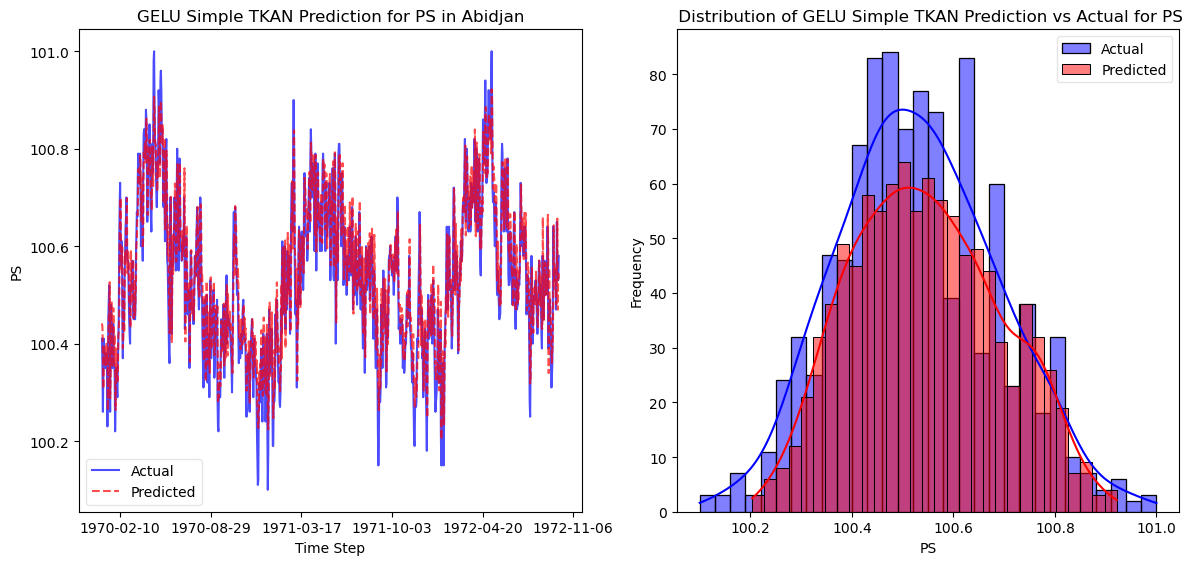

In [154]:
# import matplotlib.dates as mdates
y_true_list=[]
y_pred_list=[]
model_name="GELU Simple TKAN"
col=0
metrics_list=[]

var_name,city="PS","Abidjan"
fig, axes = plt.subplots( 1,2, figsize=(12, 6))
dates=date_test[14:]
with torch.no_grad():
    for X_batch, y_batch in Abj_test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).squeeze()
        outputs,_ = model_(X_batch)
        outputs=outputs[:, -1,:].reshape(-1, 1)
        y_true_list.append(y_batch.cpu().numpy())
        y_pred_list.append(outputs.cpu().numpy())

    # Convert lists to NumPy arrays
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    # print(y_true .shape, y_pred.shape)
    # Inverse transform
    dummy_features = np.zeros((y_true.shape[0], X_batch.shape[2]-1 ))
    actuals_padded = np.hstack([dummy_features, y_true.reshape(-1, 1)])
    predictions_padded = np.hstack([dummy_features, y_pred.reshape(-1, 1)])
    # print("actuals_padded shape:",actuals_padded.shape, "Xbatch shape:", X_batch.shape,"predictions_padded shape:",predictions_padded.shape)
    actuals_ = scaler[col].inverse_transform(actuals_padded)[:, -1] # unscaled output result 
    predictions_ = scaler[col].inverse_transform(predictions_padded)[:, -1] # unscaled prediction result 
    # print( predictions_ [:10],actuals_ [:10]) 
    # Compute metrics
    mse_ = np.mean((actuals_ - predictions_) ** 2)
    rmse_ = np.sqrt(mse_)
    mae_ = np.mean(np.abs(actuals_ - predictions_))
    r2_ = 1 - (np.sum((actuals_ - predictions_) ** 2) / np.sum((actuals_ - np.mean(actuals_)) ** 2))

    mask = actuals_ != 0
    mape_ = np.mean(np.abs((actuals_[mask] - predictions_[mask]) / actuals_[mask])* 100) if mask.any() else np.nan

    # Store metrics
    metrics_list.append({
        "City": city,
        "Model": model_name,
        "Variable": var_name,
        "MSE": round(mse_,4),
        "RMSE": round(rmse_,4),
        "MAE": round(mae_,4),
        "R²": round(r2_,4),
        "MAPE": round(mape_,4)
    })
    # --- Subplot 1: Line Plot ---
    # dates=
    axes[0].plot(dates, actuals_, label="Actual", color="blue", alpha=0.7)
    axes[0].plot(dates, predictions_, label="Predicted", color="red", linestyle="dashed", alpha=0.7)
    axes[0].set_title(f"{model_name} Prediction for {var_name} in {city}")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel(var_name)
    axes[0].legend(framealpha=0.5)
    axes[0].xaxis.set_major_locator(mdates.DayLocator(interval=200))  # Show every 7th day
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format: YYYY-MM-DD
    # plt.yscale('log')
    # axes[ 0].tick_params(axis="x", rotation=45)  # ✅ Correct


    # --- Subplot 2: Histogram ---
    sns.histplot(actuals_, label="Actual", color="blue", kde=True, bins=30, alpha=0.5, ax=axes[1])
    sns.histplot(predictions_, label="Predicted", color="red", kde=True, bins=30, alpha=0.5, ax=axes[1])
    axes[1].set_title(f" Distribution of {model_name} Prediction vs Actual for {var_name}")
    axes[1].set_xlabel(var_name)
    axes[1].set_ylabel("Frequency")
    axes[1].legend(framealpha=0.5)
    
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle

plt.savefig(f"{city}_{var_name}_{model_name}.png")
plt.show()
    # print(idx_d)
# Convert to DataFrame
metrics_df_ps = pd.DataFrame(metrics_list)

In [149]:
metrics_df_ps

,City,Model,Variable,MSE,RMSE,MAE,R²,MAPE
0,Abidjan,Simple TKAN,PS,0.0038,0.0618,0.0494,0.8464,0.0492


In [150]:
metrics_df_ps.to_latex()

'\\begin{tabular}{llllrrrrr}\n\\toprule\n & City & Model & Variable & MSE & RMSE & MAE & R² & MAPE \\\\\n\\midrule\n0 & Abidjan & Simple TKAN & PS & 0.003800 & 0.061800 & 0.049400 & 0.846400 & 0.049200 \\\\\n\\bottomrule\n\\end{tabular}\n'

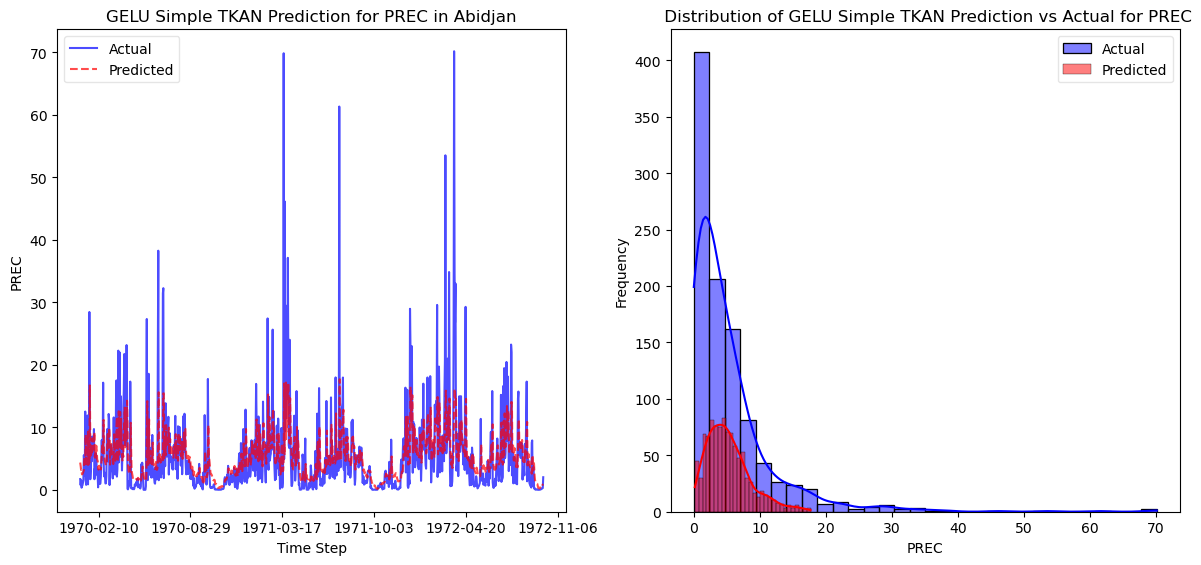

In [181]:
# import matplotlib.dates as mdates
y_true_list=[]
y_pred_list=[]
model_name="GELU Simple TKAN"
col=0
metrics_list=[]

var_name,city="PREC","Abidjan"
fig, axes = plt.subplots( 1,2, figsize=(12, 6))
dates=date_test[14:]
with torch.no_grad():
    for X_batch, y_batch in Abj_test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).squeeze()
        outputs,_ = model_(X_batch)
        outputs=outputs[:, -1,:].reshape(-1, 1)
        y_true_list.append(y_batch.cpu().numpy())
        y_pred_list.append(outputs.cpu().numpy())

    # Convert lists to NumPy arrays
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    # print(y_true .shape, y_pred.shape)
    # Inverse transform
    dummy_features = np.zeros((y_true.shape[0], X_batch.shape[2]-1 ))
    actuals_padded = np.hstack([dummy_features, y_true.reshape(-1, 1)])
    predictions_padded = np.hstack([dummy_features, y_pred.reshape(-1, 1)])
    # print("actuals_padded shape:",actuals_padded.shape, "Xbatch shape:", X_batch.shape,"predictions_padded shape:",predictions_padded.shape)
    actuals_ = scaler[col].inverse_transform(actuals_padded)[:, -1] # unscaled output result 
    predictions_ = scaler[col].inverse_transform(predictions_padded)[:, -1] # unscaled prediction result 
    # print( predictions_ [:10],actuals_ [:10]) 
    # Compute metrics
    mse_ = np.mean((actuals_ - predictions_) ** 2)
    rmse_ = np.sqrt(mse_)
    mae_ = np.mean(np.abs(actuals_ - predictions_))
    r2_ = 1 - (np.sum((actuals_ - predictions_) ** 2) / np.sum((actuals_ - np.mean(actuals_)) ** 2))

    mask = actuals_ != 0
    mape_ = np.mean(np.abs((actuals_[mask] - predictions_[mask]) / actuals_[mask])* 100) if mask.any() else np.nan

    # Store metrics
    metrics_list.append({
        "City": city,
        "Model": model_name,
        "Variable": var_name,
        "MSE": round(mse_,4),
        "RMSE": round(rmse_,4),
        "MAE": round(mae_,4),
        "R²": round(r2_,4),
        "MAPE": round(mape_,4)
    })
    # --- Subplot 1: Line Plot ---
    # dates=
    axes[0].plot(dates, actuals_, label="Actual", color="blue", alpha=0.7)
    axes[0].plot(dates, predictions_, label="Predicted", color="red", linestyle="dashed", alpha=0.7)
    axes[0].set_title(f"{model_name} Prediction for {var_name} in {city}")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel(var_name)
    axes[0].legend(framealpha=0.5)
    axes[0].xaxis.set_major_locator(mdates.DayLocator(interval=200))  # Show every 7th day
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format: YYYY-MM-DD
    # plt.yscale('log')
    # axes[ 0].tick_params(axis="x", rotation=45)  # ✅ Correct

    # --- Subplot 2: Histogram ---
    sns.histplot(actuals_, label="Actual", color="blue", kde=True, bins=30, alpha=0.5, ax=axes[1])
    sns.histplot(predictions_, label="Predicted", color="red", kde=True, bins=30, alpha=0.5, ax=axes[1])
    axes[1].set_title(f" Distribution of {model_name} Prediction vs Actual for {var_name}")
    axes[1].set_xlabel(var_name)
    axes[1].set_ylabel("Frequency")
    axes[1].legend(framealpha=0.5)
    
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
plt.savefig(f"{city}_{var_name}_{model_name}.png")
plt.show()
    # print(idx_d)
# Convert to DataFrame
metrics_df_prec = pd.DataFrame(metrics_list)

## Kigali

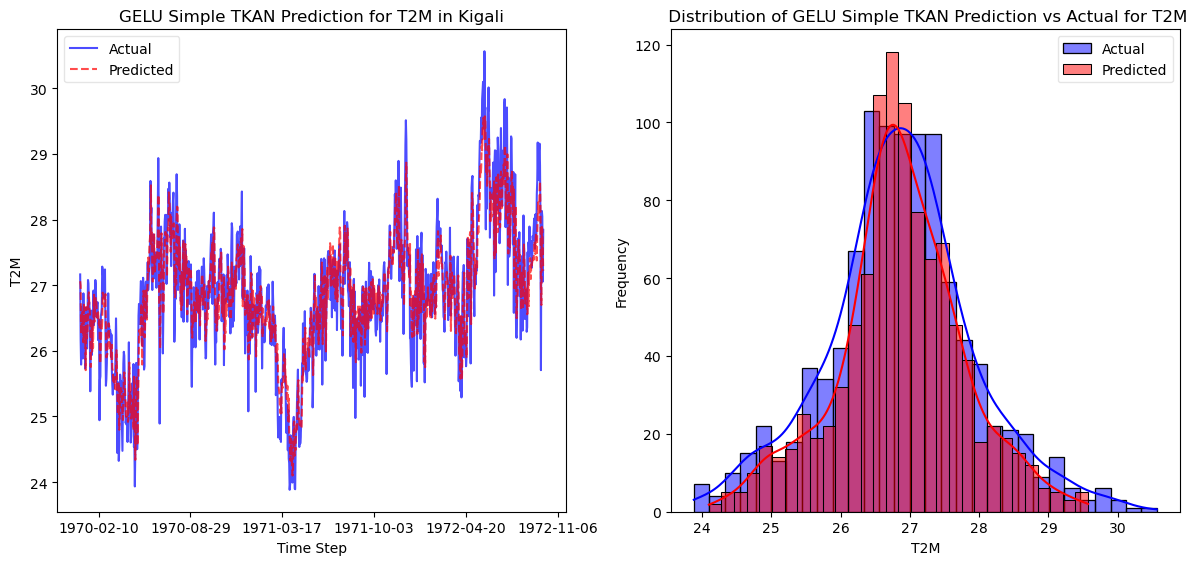

In [169]:
# import matplotlib.dates as mdates
y_true_list=[]
y_pred_list=[]
model_name="GELU Simple TKAN"
col=0
metrics_list=[]

var_name,city="T2M","Kigali"
fig, axes = plt.subplots( 1,2, figsize=(12, 6))
dates=date_test[14:]
with torch.no_grad():
    for X_batch, y_batch in Kgl_test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).squeeze()
        outputs,_ = model(X_batch)
        outputs=outputs[:, -1,:].reshape(-1, 1)
        y_true_list.append(y_batch.cpu().numpy())
        y_pred_list.append(outputs.cpu().numpy())

    # Convert lists to NumPy arrays
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    # print(y_true .shape, y_pred.shape)
    # Inverse transform
    dummy_features = np.zeros((y_true.shape[0], X_batch.shape[2]-1 ))
    actuals_padded = np.hstack([dummy_features, y_true.reshape(-1, 1)])
    predictions_padded = np.hstack([dummy_features, y_pred.reshape(-1, 1)])
    # print("actuals_padded shape:",actuals_padded.shape, "Xbatch shape:", X_batch.shape,"predictions_padded shape:",predictions_padded.shape)
    actuals_ = scaler[col].inverse_transform(actuals_padded)[:, -1] # unscaled output result 
    predictions_ = scaler[col].inverse_transform(predictions_padded)[:, -1] # unscaled prediction result 
    # print( predictions_ [:10],actuals_ [:10]) 
    # Compute metrics
    mse_ = np.mean((actuals_ - predictions_) ** 2)
    rmse_ = np.sqrt(mse_)
    mae_ = np.mean(np.abs(actuals_ - predictions_))
    r2_ = 1 - (np.sum((actuals_ - predictions_) ** 2) / np.sum((actuals_ - np.mean(actuals_)) ** 2))

    mask = actuals_ != 0
    mape_ = np.mean(np.abs((actuals_[mask] - predictions_[mask]) / actuals_[mask])* 100) if mask.any() else np.nan

    # Store metrics
    metrics_list.append({
        "City": city,
        "Model": model_name,
        "Variable": var_name,
        "MSE": round(mse_,4),
        "RMSE": round(rmse_,4),
        "MAE": round(mae_,4),
        "R²": round(r2_,4),
        "MAPE": round(mape_,4)
    })
    # --- Subplot 1: Line Plot ---
    # dates=
    axes[0].plot(dates, actuals_, label="Actual", color="blue", alpha=0.7)
    axes[0].plot(dates, predictions_, label="Predicted", color="red", linestyle="dashed", alpha=0.7)
    axes[0].set_title(f"{model_name} Prediction for {var_name} in {city}")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel(var_name)
    axes[0].legend(framealpha=0.5)
    axes[0].xaxis.set_major_locator(mdates.DayLocator(interval=200))  # Show every 7th day
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format: YYYY-MM-DD
    # plt.yscale('log')
    # axes[ 0].tick_params(axis="x", rotation=45)  # ✅ Correct


    # --- Subplot 2: Histogram ---
    sns.histplot(actuals_, label="Actual", color="blue", kde=True, bins=30, alpha=0.5, ax=axes[1])
    sns.histplot(predictions_, label="Predicted", color="red", kde=True, bins=30, alpha=0.5, ax=axes[1])
    axes[1].set_title(f" Distribution of {model_name} Prediction vs Actual for {var_name}")
    axes[1].set_xlabel(var_name)
    axes[1].set_ylabel("Frequency")
    axes[1].legend(framealpha=0.5)
    
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
plt.savefig(f"{city}_{var_name}_{model_name}.png")
plt.show()
    # print(idx_d)
# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)

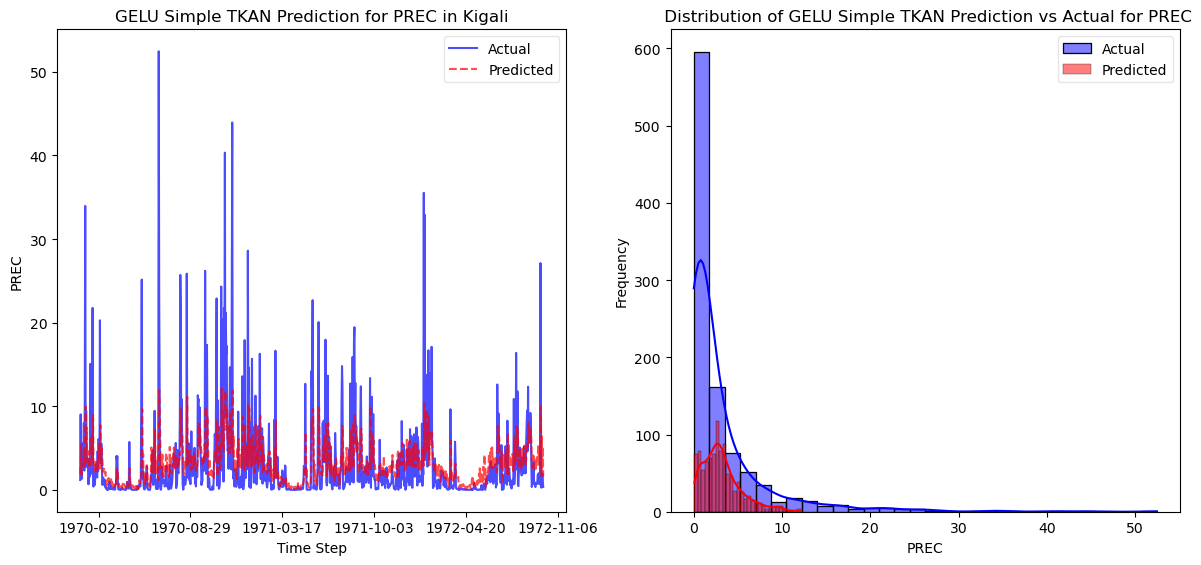

In [226]:
# import matplotlib.dates as mdates
y_true_list=[]
y_pred_list=[]
model_name="GELU Simple TKAN"
col=0
metrics_list=[]

var_name,city="PREC","Kigali"
fig, axes = plt.subplots( 1,2, figsize=(12, 6))
dates=date_test[14:]
with torch.no_grad():
    for X_batch, y_batch in Kgl_test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).squeeze()
        outputs,_ = model(X_batch)
        outputs=outputs[:, -1,:].reshape(-1, 1)
        y_true_list.append(y_batch.cpu().numpy())
        y_pred_list.append(outputs.cpu().numpy())

    # Convert lists to NumPy arrays
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    # print(y_true .shape, y_pred.shape)
    # Inverse transform
    dummy_features = np.zeros((y_true.shape[0], X_batch.shape[2]-1 ))
    actuals_padded = np.hstack([dummy_features, y_true.reshape(-1, 1)])
    predictions_padded = np.hstack([dummy_features, y_pred.reshape(-1, 1)])
    # print("actuals_padded shape:",actuals_padded.shape, "Xbatch shape:", X_batch.shape,"predictions_padded shape:",predictions_padded.shape)
    actuals_ = scaler[col].inverse_transform(actuals_padded)[:, -1] # unscaled output result 
    predictions_ = scaler[col].inverse_transform(predictions_padded)[:, -1] # unscaled prediction result 
    # print( predictions_ [:10],actuals_ [:10]) 
    # Compute metrics
    mse_ = np.mean((actuals_ - predictions_) ** 2)
    rmse_ = np.sqrt(mse_)
    mae_ = np.mean(np.abs(actuals_ - predictions_))
    r2_ = 1 - (np.sum((actuals_ - predictions_) ** 2) / np.sum((actuals_ - np.mean(actuals_)) ** 2))

    mask = actuals_ != 0
    mape_ = np.mean(np.abs((actuals_[mask] - predictions_[mask]) / actuals_[mask])* 100) if mask.any() else np.nan

    # Store metrics
    metrics_list.append({
        "City": city,
        "Model": model_name,
        "Variable": var_name,
        "MSE": round(mse_,4),
        "RMSE": round(rmse_,4),
        "MAE": round(mae_,4),
        "R²": round(r2_,4),
        "MAPE": round(mape_,4)
    })
    # --- Subplot 1: Line Plot ---
    # dates=
    axes[0].plot(dates, actuals_, label="Actual", color="blue", alpha=0.7)
    axes[0].plot(dates, predictions_, label="Predicted", color="red", linestyle="dashed", alpha=0.7)
    axes[0].set_title(f"{model_name} Prediction for {var_name} in {city}")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel(var_name)
    axes[0].legend(framealpha=0.5)
    axes[0].xaxis.set_major_locator(mdates.DayLocator(interval=200))  # Show every 7th day
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format: YYYY-MM-DD
    # plt.yscale('log')
    # axes[ 0].tick_params(axis="x", rotation=45)  # ✅ Correct


    # --- Subplot 2: Histogram ---
    sns.histplot(actuals_, label="Actual", color="blue", kde=True, bins=30, alpha=0.5, ax=axes[1])
    sns.histplot(predictions_, label="Predicted", color="red", kde=True, bins=30, alpha=0.5, ax=axes[1])
    axes[1].set_title(f" Distribution of {model_name} Prediction vs Actual for {var_name}")
    axes[1].set_xlabel(var_name)
    axes[1].set_ylabel("Frequency")
    axes[1].legend(framealpha=0.5)
    
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle

plt.savefig(f"{city}_{var_name}_{model_name}.png")
plt.show()
    # print(idx_d)
# Convert to DataFrame
metrics_df_kgl_prec = pd.DataFrame(metrics_list)

In [227]:
metrics_df_kgl_prec

,City,Model,Variable,MSE,RMSE,MAE,R²,MAPE
0,Kigali,GELU Simple TKAN,PREC,21.6519,4.6532,2.541,0.2247,744.7792


In [186]:
metrics_df_kgl_prec.to_latex()

'\\begin{tabular}{llllrrrrr}\n\\toprule\n & City & Model & Variable & MSE & RMSE & MAE & R² & MAPE \\\\\n\\midrule\n0 & Kigali & GELU Simple TKAN & PREC & 22.320500 & 4.724500 & 2.616100 & 0.200700 & 828.995300 \\\\\n\\bottomrule\n\\end{tabular}\n'

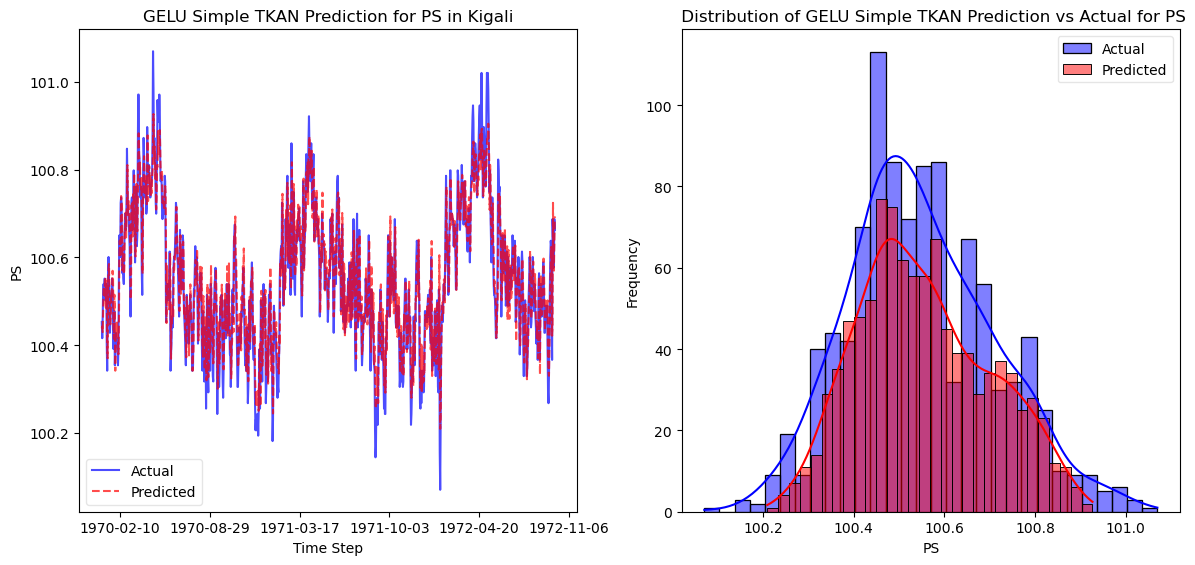

In [155]:
# import matplotlib.dates as mdates
y_true_list=[]
y_pred_list=[]
model_name="GELU Simple TKAN"
col=0
metrics_list=[]

var_name,city="PS","Kigali"
fig, axes = plt.subplots( 1,2, figsize=(12, 6))
dates=date_test[14:]
with torch.no_grad():
    for X_batch, y_batch in Kgl_test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).squeeze()
        outputs,_ = model(X_batch)
        outputs=outputs[:, -1,:].reshape(-1, 1)
        y_true_list.append(y_batch.cpu().numpy())
        y_pred_list.append(outputs.cpu().numpy())

    # Convert lists to NumPy arrays
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    # print(y_true .shape, y_pred.shape)
    # Inverse transform
    dummy_features = np.zeros((y_true.shape[0], X_batch.shape[2]-1 ))
    actuals_padded = np.hstack([dummy_features, y_true.reshape(-1, 1)])
    predictions_padded = np.hstack([dummy_features, y_pred.reshape(-1, 1)])
    # print("actuals_padded shape:",actuals_padded.shape, "Xbatch shape:", X_batch.shape,"predictions_padded shape:",predictions_padded.shape)
    actuals_ = scaler[col].inverse_transform(actuals_padded)[:, -1] # unscaled output result 
    predictions_ = scaler[col].inverse_transform(predictions_padded)[:, -1] # unscaled prediction result 
    # print( predictions_ [:10],actuals_ [:10]) 
    # Compute metrics
    mse_ = np.mean((actuals_ - predictions_) ** 2)
    rmse_ = np.sqrt(mse_)
    mae_ = np.mean(np.abs(actuals_ - predictions_))
    r2_ = 1 - (np.sum((actuals_ - predictions_) ** 2) / np.sum((actuals_ - np.mean(actuals_)) ** 2))

    mask = actuals_ != 0
    mape_ = np.mean(np.abs((actuals_[mask] - predictions_[mask]) / actuals_[mask])* 100) if mask.any() else np.nan

    # Store metrics
    metrics_list.append({
        "City": city,
        "Model": model_name,
        "Variable": var_name,
        "MSE": round(mse_,4),
        "RMSE": round(rmse_,4),
        "MAE": round(mae_,4),
        "R²": round(r2_,4),
        "MAPE": round(mape_,4)
    })
    # --- Subplot 1: Line Plot ---
    # dates=
    axes[0].plot(dates, actuals_, label="Actual", color="blue", alpha=0.7)
    axes[0].plot(dates, predictions_, label="Predicted", color="red", linestyle="dashed", alpha=0.7)
    axes[0].set_title(f"{model_name} Prediction for {var_name} in {city}")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel(var_name)
    axes[0].legend(framealpha=0.5)
    axes[0].xaxis.set_major_locator(mdates.DayLocator(interval=200))  # Show every 7th day
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format: YYYY-MM-DD
    # plt.yscale('log')
    # axes[ 0].tick_params(axis="x", rotation=45)  # ✅ Correct


    # --- Subplot 2: Histogram ---
    sns.histplot(actuals_, label="Actual", color="blue", kde=True, bins=30, alpha=0.5, ax=axes[1])
    sns.histplot(predictions_, label="Predicted", color="red", kde=True, bins=30, alpha=0.5, ax=axes[1])
    axes[1].set_title(f" Distribution of {model_name} Prediction vs Actual for {var_name}")
    axes[1].set_xlabel(var_name)
    axes[1].set_ylabel("Frequency")
    axes[1].legend(framealpha=0.5)
    
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
plt.savefig(f"{city}_{var_name}_{model_name}.png")
plt.show()
    # print(idx_d)
# Convert to DataFrame
metrics_df_kgl_ps = pd.DataFrame(metrics_list)

In [152]:
metrics_df_kgl_ps

,City,Model,Variable,MSE,RMSE,MAE,R²,MAPE
0,Kigali,Simple TKAN,PS,0.0039,0.0623,0.0491,0.8516,0.0488
